In [ ]:
!pip install Pillow
!pip install keras-unet
!pip install transformers

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from skimage.io import imread
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
from keras_unet.models import custom_unet
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import to_categorical
from keras.optimizers import Adam
from PIL import Image


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.models import load_model

# Load the model
base_model = load_model('/content/drive/MyDrive/Brain Tumor data/mobilenetv2_model.h5')

In [ ]:
# paths for training and testing sets
training_set = '/content/drive/MyDrive/Brain Tumor data/Training'
test_set = '/content/drive/MyDrive/Brain Tumor data/Testing'

In [ ]:
# preprocess training set and save to drive
def preprocess_images(training_set, target_set, target_size=(512, 512)):
  if not os.path.exists(target_set):
        os.makedirs(target_set)

  preprocessed_data = []
  tumor_types = ["glioma", "meningioma", "notumor", "pituitary"]
  for tumor_type in tumor_types:
    type_path = os.path.join(training_set, tumor_type)
    target_type_path = os.path.join(target_set, tumor_type)

    if not os.path.exists(target_type_path):
            os.makedirs(target_type_path)

    if os.path.isdir(type_path):
      print(f"Processing directory: {type_path}")

      for image_name in os.listdir(type_path):
        image_path = os.path.join(type_path, image_name)
        target_image_path = os.path.join(target_type_path, image_name)
        image = cv2.imread(image_path)
        if image is not None:
          image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          pil_image = Image.fromarray(image_rgb)
          resized_image = pil_image.resize((512, 512))
          resized_image.save(target_image_path)
          print(f"Saved image: {target_image_path}")
        else:
          print(f"Failed to read image: {image_path}")

training_set = '/content/drive/MyDrive/Brain Tumor data/Training'
resized_set = '/content/drive/MyDrive/Brain Tumor data/Resized Training'
preprocessed_data = preprocess_images(training_set, resized_set, (512, 512))


In [ ]:
# preprocess test set and save to drive
def preprocess_images(test_set, target_set, target_size=(512, 512)):
  if not os.path.exists(target_set):
        os.makedirs(target_set)

  preprocessed_data = []
  tumor_types = ["glioma", "meningioma", "notumor", "pituitary"]
  for tumor_type in tumor_types:
    type_path = os.path.join(test_set, tumor_type)
    target_type_path = os.path.join(target_set, tumor_type)

    if not os.path.exists(target_type_path):
            os.makedirs(target_type_path)

    if os.path.isdir(type_path):
      print(f"Processing directory: {type_path}")

      for image_name in os.listdir(type_path):
        image_path = os.path.join(type_path, image_name)
        target_image_path = os.path.join(target_type_path, image_name)
        image = cv2.imread(image_path)
        if image is not None:
          image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          pil_image = Image.fromarray(image_rgb)
          resized_image = pil_image.resize((512, 512))
          resized_image.save(target_image_path)
          print(f"Saved image: {target_image_path}")
        else:
          print(f"Failed to read image: {image_path}")

test_set = '/content/drive/MyDrive/Brain Tumor data/Testing'
resized_set = '/content/drive/MyDrive/Brain Tumor data/Resized Testing'
preprocessed_data = preprocess_images(test_set, resized_set, (512, 512))

In [ ]:
# transfer learning method
from keras.applications import MobileNetV2
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.000066),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.optimizers import Adam

# Load the trained model
model_path = '/content/drive/MyDrive/Brain Tumor data/model_57acc.h5'
base_model = load_model(model_path)

# Compile model
base_model.compile(optimizer=Adam(learning_rate=0.000066),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# load preprocessed images
resized_training = '/content/drive/MyDrive/Brain Tumor data/Resized Training'
resized_testing = '/content/drive/MyDrive/Brain Tumor data/Resized Testing'

# data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Validation data generator (no augmentation)
valid_datagen = ImageDataGenerator(rescale=1./255)

# generator for training data
train_generator = datagen.flow_from_directory(
    resized_training,
    target_size=(512, 512),
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

# generator for validation data
valid_generator = train_datagen.flow_from_directory(
    resized_training,
    target_size=(512, 512),
    batch_size=64,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

# generator for testing data
test_generator = datagen.flow_from_directory(
    resized_testing,
    target_size=(512, 512),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

print("Training Class:", train_generator.n)
print("Validation Class:", valid_generator.n)
print("Testing Class:", test_generator.n)


Found 4595 images belonging to 4 classes.
Found 1147 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Training Class: 4595
Validation Class: 1147
Testing Class: 1311


In [ ]:
## MODEL TRAINING

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Callbacks for saving progress
checkpoint_callback = ModelCheckpoint(
    '/content/drive/MyDrive/Brain Tumor data/mobilenetv2.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = valid_generator.n // valid_generator.batch_size
test_steps = test_generator.n // test_generator.batch_size

print("Starting training...")
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=1,
    validation_data=valid_generator,
    validation_steps=50,
    callbacks=[checkpoint_callback]
)

print("Training complete.") #Evaluating the model...")

# Evaluate the model on the test set
#test_loss, test_acc = base_model.evaluate(test_generator, steps=5)
#print(f"Test accuracy: {test_acc}")
#print(f"Test loss: {test_loss}")



Starting training...
50/50 [==============================] - ETA: 0s - loss: 0.9989 - accuracy: 0.5918

50/50 [==============================] - 582s 11s/step - loss: 0.9989 - accuracy: 0.5918 - val_loss: 1.4481 - val_accuracy: 0.3418
Training complete.


In [ ]:
# MODEL TESTING

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator


model_path = '/content/drive/MyDrive/Brain Tumor data/model_57acc.h5'
base_model = load_model(model_path)

datagen = ImageDataGenerator(rescale=1./255)
resized_testing = '/content/drive/MyDrive/Brain Tumor data/Resized Testing'


test_generator = datagen.flow_from_directory(
    resized_testing,
    target_size=(512, 512),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the loaded model on the test set
test_loss, test_acc = base_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")


Found 1311 images belonging to 4 classes.
21/21 [==============================] - 223s 11s/step - loss: 2.9273 - accuracy: 0.5736
Test accuracy: 0.5736079216003418
Test loss: 2.927269458770752


In [ ]:
# Save the model
base_model.save('/content/drive/MyDrive/Brain Tumor data/mobilenetv2_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# model summary
base_model.summary()

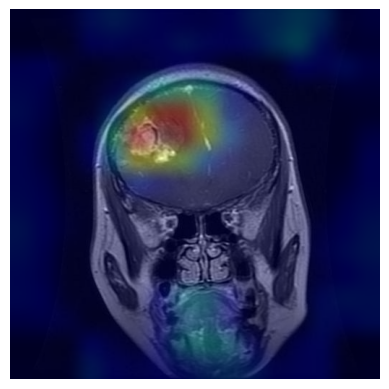

In [ ]:
## GRAD-CAM INTEGRATION

import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import load_model, Model
from keras.layers import Conv2D
import tensorflow as tf
import matplotlib

#load model
model_path = '/content/drive/MyDrive/Brain Tumor data/model_57acc.h5'
base_model = load_model(model_path)


conv_layers = [layer for layer in base_model.layers if isinstance(layer, Conv2D)]

# pick a layer to visualize
chosen_layer = conv_layers[-1].name # last conv layer

def get_img_array(img_path, size):
  img = image.load_img(img_path, target_size=size)
  array = image.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  array = array / 255.0
  return array


def make_gradcam_map(img_array, layer_name, model, pred_index=None):
  grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(chosen_layer).output, model.output])
  with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    if pred_index is None:
      pred_index = tf.argmax(predictions[0]) # finds class index w/ highest predicted score
    class_channel = predictions[:, pred_index]

  grads = tape.gradient(class_channel, conv_outputs)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  conv_outputs = conv_outputs[0]
  heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
  img = image.load_img(img_path)
  img = image.img_to_array(img)
  heatmap = np.uint8(255 * heatmap)

  jet = matplotlib.colormaps['jet']
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = image.img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = image.array_to_img(superimposed_img)
  superimposed_img.save(cam_path)

  plt.imshow(superimposed_img)
  plt.axis('off')
  plt.show()

#img_path = '/content/drive/MyDrive/Brain Tumor data/Resized Testing/glioma/Te-glTr_0004.jpg'
img_path = '/content/drive/MyDrive/Brain Tumor data/Resized Training/glioma/Tr-glTr_0000.jpg'
#img_path = '/content/drive/MyDrive/Brain Tumor data/Resized Testing/glioma/Te-glTr_0003.jpg'
img_array = get_img_array(img_path, (512, 512))
heatmap = make_gradcam_map(img_array, chosen_layer, base_model)
display_gradcam(img_path, heatmap)